In [43]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jul 13 08:10:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |   1119MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
#########################################################################
## MONTAR DRIVE
#########################################################################
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
!pip install stable_baselines3

In [46]:
#########################################################################
## LIBRERIAS NECESARIAS
#########################################################################
import tensorflow as tf
import gymnasium as gym
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
import copy
import torch
from sklearn.model_selection import train_test_split

import sys

import os
from stable_baselines3.common.vec_env import DummyVecEnv

In [47]:
############################################################################
## Variables globales
###########################################################################
BATCH_SIZE=32
EPOCHS=100
EPISODES=5
EPISODES_EVALUATE_G=10

# Gym CartPole-v1

Un péndulo está unido mediante una articulación no accionada a un carro que se desplaza a lo largo de una pista sin fricción. El péndulo se coloca verticalmente sobre el carro y el objetivo es equilibrar el poste aplicando fuerzas en dirección izquierda y derecha sobre el carro.

**Espacio de Acciones**: Espacio discreto de tamaño (2)
 * Acción 0: Empujar el carro hacia la izquierda
 * Acción 1: Empujar el carro hacia la derecha

    
   
**Espacio de Observaciones**: Espacio discreto de tamaño (4,)

* La observación es un ndarray con forma (4,) con los valores correspondientes a las siguientes posiciones y velocidades:
         Num    Observación                         Min                            Max

          0    Posición del Carro                 - 4.8                            4.8

          1    Velocidad del Carro                 -Inf                            Inf

          2    Ángulo del Poste              ~ -0.418 rad (-24°)          ~ 0.418 rad (24°)

          3    Velocidad Angular del Poste         -Inf                            Inf

                

In [48]:
# Definimos el entorno
env= gym.make('CartPole-v1')

# Obtenemos el espacio de estados y acciones del entorno
ob_space=env.observation_space

# Mostramos el número de acciones del entorno
print(env.action_space.n)

2




# Discriminador

## Red neuronal del Discriminador

In [49]:
# Red neuronal del Discriminador
# Input: listas de longitud 6, [s,a]
# Output: probabilidad de real o falso [0,1]
discriminator_net=keras.Sequential(
    [
        keras.Input(shape=(None,ob_space.shape[0]+2)),
        layers.Dense(units=20,activation=tf.nn.leaky_relu, name='layer1'),
        layers.Dense(units=20,activation=tf.nn.leaky_relu, name='layer2'),
        layers.Dense(units=20, activation=tf.nn.leaky_relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

Model: "discriminator_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 20)          140       
                                                                 
 layer2 (Dense)              (None, None, 20)          420       
                                                                 
 layer3 (Dense)              (None, None, 20)          420       
                                                                 
 prob (Dense)                (None, None, 1)           21        
                                                                 
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


## Función de pérdida del Discriminador

In [50]:
# Función de pérdida del Discriminador
# prob1=>output de la red neuronal anterior cuando recibe como entrada [s,a] de la base de datos, REAL
# prob2=>output de la red neuronal anterior cuando recibe como entrada [s,a] FALSO
def loss_fn_D(prob1, prob2):
    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REA
    loss_expert=tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1,0.01,1)))

    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent=tf.reduce_mean(tf.math.log(tf.clip_by_value(1-prob2,0.01,1)))
    loss_expert=tf.cast(loss_expert, dtype=tf.float32)
    loss_agent=tf.cast(loss_agent, dtype=tf.float32)
    loss=loss_expert+loss_agent
    loss=-loss


    return loss

## Clase del Discriminador

In [51]:
# Clase DISCRIMINADOR
class Discriminator:
    def __init__(self, env, discriminator_net, expert_s, expert_a, agent_s, agent_a):
        # -Red neuronal del Discriminador
        self.discriminator_net=discriminator_net
        # -Experto: [s,a]
        self.expert_s=expert_s
        self.expert_a=expert_a
        expert_a_one_hot=tf.one_hot(self.expert_a,depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot+= tf.random.normal(tf.shape(expert_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.expert_s_a=tf.concat([self.expert_s,expert_a_one_hot],axis=1)

        # -Agente:  [s,a]
        self.agent_s=agent_s
        self.agent_a=agent_a
        agent_a_one_hot=tf.one_hot(self.agent_a,depth=env.action_space.n)
        agent_a_one_hot+= tf.random.normal(tf.shape(agent_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.agent_s_a=tf.concat([self.agent_s,agent_a_one_hot],axis=1)



        # Calculamos la salida de la red para [s,a] del experto y del agente ya que lo necesitamos para reward

        # -Salida de la red neuronal Discriminador para [s,a] expertos(verdaderos)
        self.prob_expert=self.discriminator_net(self.expert_s_a)

        # -Salida  de la red neuronal Discrimiinador para [s,a] Agente(falsos)
        self.prob_agent=self.discriminator_net(self.agent_s_a)

        #-Recompensa obtenida cuando el Agente realiza [s,a] falsas
        self.rewards=tf.math.log(tf.clip_by_value(self.prob_agent,1e-10,1)) #log(P(expert|s,a)) cuando mas grande es mejor el agente


    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards



# Generador

## Redes neuronales del Generador

In [52]:
# Red neuronal del Generador donde se producen acciones
# Input: estados, listas de tamaño 4, s=[s0,s1,s2,s3]
# Output: acciones, listas de tamaño 2, a=[a0,a1]
generator_net_Act=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=20, activation=tf.tanh,name='layer1'),
            layers.Dense(units=20, activation=tf.tanh, name='layer2'),
            layers.Dense(units=2, activation=tf.tanh, name='layer3'),
            layers.Dense(units=2, activation=tf.nn.softmax, name='layer4')

        ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 20)          100       
                                                                 
 layer2 (Dense)              (None, None, 20)          420       
                                                                 
 layer3 (Dense)              (None, None, 2)           42        
                                                                 
 layer4 (Dense)              (None, None, 2)           6         
                                                                 
Total params: 568
Trainable params: 568
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Red neuronal del Generador donde se producen v_pred
# Input: estados, listas de tamaño 4, s=[s0,s1,s2,s3]
# Output: v_pred, listas de tamaño 1, v_pred

generator_net_v_preds=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=20, activation=tf.tanh,name='layer1'),
            layers.Dense(units=20, activation=tf.tanh, name='layer2'),
            layers.Dense(units=1, activation=None, name='layer3'),
        ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()

Model: "generator_v_preds"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 20)          100       
                                                                 
 layer2 (Dense)              (None, None, 20)          420       
                                                                 
 layer3 (Dense)              (None, None, 1)           21        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


## Función de pérdida del Generador

In [54]:
# Función de pérdida del Generador
def loss_fn_ppo(act_probs, act_probs_old, gaes, clip_value=0.2):
    #--> Construir el calculo del grafo para loss_clip

    ratios=tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios= tf.clip_by_value(ratios, clip_value_min=1 - clip_value, clip_value_max=1 + clip_value)
    loss_clip=tf.minimum(tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)

    # minimizar -loss == maximizar loss
    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del Generador

In [55]:
# Clase del GENERADOR: política con su optimizador PPO
# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase
# Policy_net en lugar de generator
class Policy_net:
    def __init__(self, name: str, env, obs):
        """
        env: gym env
        obs:
        """
        # -Entorno
        self.env=env

        env.reset()

        # -El algoritmo de Optimización de Política Proximal, PPO, combina ideas del algoritmo A2C
        # (que utiliza múltiples trabajadores) y del algoritmo TRPO (que utiliza una región de confianza para
        # mejorar el actor).
        self.model=PPO(policy="MlpPolicy", env=env, verbose=0)


        self.model.learn(total_timesteps=25)

        # -Observación inicial a partir de la cual se crean las acciones iniciales
        # haciendo uso de las redes neuronales del generador
        self.obs=np.reshape(np.array(obs),(1,4))

        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs =generator_net_Act(self.obs)
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)



    # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
    # La elección de la acción puede ser estocástica o determinística
    def act(self, stochastic=True):
        if stochastic:
            return self.act_stochastic, self.v_preds
        else:
            return self.act_deterministic, self.v_preds

    def get_action_prob(self):
        return self.act_probs

    def get_v_preds(self):
        return self.v_preds

    def get_obs(self):
        return self.obs

    def get_model(self):
        return self.model

    def get_trainable_variables(self):
        return self.model.get_parameters()

    # Generar [s,a] falsos
    def generate_fakes(self):

        ob_space = env.observation_space
        reward = 0
        success_num = 0


        # Por cada episodio
        for iteration in range(EPISODES):
            # Inicializo todas las variables
            observations = []
            actions = []
            rewards = []
            run_policy_steps = 0

            truncated=False
            terminated=False


            #La primera acción de cada episodio se crea con la red neuronal

            obs,_=env.reset()

            Old_Policy = Policy_net('old_policy', env, obs=obs)

            act, v_pred = Old_Policy.act(stochastic=True)

            #Convertir de tensor a array
            if type(act)=='Tensor':
                # Crear una sesión de TensorFlow
                sess = tf.compat.v1.Session()

                # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
                act = sess.run(act)

                # Cerrar la sesión
                sess.close()

            if isinstance(act, tf.Tensor):
                act=act.numpy()

            elif isinstance(act, np.ndarray):
                act=act


            action=int(act)

            next_obs,reward,terminated,truncated, info=env.step(action)

            # --Actualización de variables: ojo no introduzco el estado y accion inicial, solo introduzco los de PPO
            observations.append(next_obs)  # S_0

            Policy = Policy_net('policy',env, obs=[next_obs]) # tenemos una política entrenada

            # Por cada steps en cada episodio, mientras no se llegue a un estado terminal o un estado malo
            while terminated!= True and truncated!= True:
                # --Aumentar el numero de steps
                run_policy_steps += 1

                # --Política para ver la acción asociada al estado
                # Las observaciones son un de la forma [[s_0,s_1,s_2,s_3]] por eso su tamaño es (1,4)
                action, states_oc = Policy.get_model().predict(next_obs)

                action=int(action)

                # --Muevo al Agente al siguiente estado
                next_obs,reward,terminated,truncated,info=env.step(action)

                # --Actualización de variables
                actions.append(action) # A_i-1
                rewards.append(reward) # R_i-1

                # -- Muestro visualización gráfica
                # env.render()


                # --Si llegamos a un estado final, el juego ha finalizado!!!
                # --Se configura el tablero de nuevo
                if terminated== True:
                    obs = env.reset()
                    reward = -1
                    break
                else:
                    observations.append(next_obs) # O_i
                    self.obs = next_obs

            # Ver si el episodio ha obtendo una recompensa total igual o superior a 195
            if sum(rewards) >= 195:
                success_num += 1
                render = True
                if success_num >= 100:
                    break
            else:
                success_num = 0


        observations = np.reshape(observations, newshape=[-1] + list(ob_space.shape))
        actions = np.array(actions).astype(dtype=np.int32)


        return observations, actions, rewards, Old_Policy, Policy



## PPO Train

In [56]:
# Clase PPOTrain
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores
# gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, calculo de gradiente y función de pérdida del PPO para despues usarlo en el generador
# de la GAN
class PPOTrain:

    def __init__(self, Policy, Old_Policy, obs, actions, rewards, gamma=0.95, clip_value=0.2, c_1=1, c_2=0.01):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs=obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()


        policy_name = "policy"
        old_policy_name="policy"

        policy_dict_ = self.pi_trainable[policy_name]
        old_policy_dict_=self.old_pi_trainable[old_policy_name]

        self.pi=[]
        if policy_name in self.pi_trainable:
            if old_policy_name in self.old_pi_trainable:
                for param_name, param_value in policy_dict_.items():
                    # Elimino los pesos que hay en old_policy
                    del old_policy_dict_[param_name]
                    # Introduzco los pesos de old_policy en policy
                    old_policy_dict_[param_name] = param_value
                    # OJOO LOS PESOS ESTÁN AQUI
                    self.pi.append(param_value)
        else:
            print(f"No se encontró la política con el nombre: {policy_name}")


        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos nuevos pi_trainable


        self.actions = actions
        self.rewards=rewards
        self.v_preds=self.Old_Policy.get_v_preds()
        self.v_preds_next=self.Policy.get_v_preds()

        #  generative advantage estimator(lambda = 1), see ppo paper eq(11)
        self.gaes =self.get_gaes(self.rewards, self.v_preds, self.v_preds_next)

        act_probs =self.Policy.get_action_prob()
        act_probs_old =self.Old_Policy.get_action_prob()

        # probabilities of actions which agent took with policy
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # probabilities of actions which agent took with old policy
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss=loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer =tf.keras.optimizers.Adam(learning_rate=0.001)

    def loss_fn_G(self):
        return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

    def get_pi_trainable(self):
        return self.pi

    def get_optimizer(self):
        return self.optimizer

    def get_OldPolicy(self):
        return self.Old_Policy

    def get_Policy(self):
        return self.Policy

    def get_gaes(self, rewards, v_preds, v_preds_next):
        deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
        # calculate generative advantage estimator(lambda = 1), see ppo paper eq(11)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) - 1)):  # is T-1, where T is time step which run policy
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes

# GAIL

In [57]:
####################################################################################################################
# CLASE GAIL
####################################################################################################################
class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator=Policy_net
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self,d_optimizer, loss_fn_D ):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D=  loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
        len_real = X_test.shape[0]

        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes(self.generator)

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        dataset_gen=np.concatenate([generate_observations,generate_a_one_hot],axis=1)


        len_fakes=dataset_gen.shape[0]

        # Compilamos el discriminador como CNN
        self.discriminator.discriminator_net.compile(optimizer=self.d_optimizer, loss=self.loss_fn_D, metrics=['accuracy'])

        # Evaluamos como CNN
        loss_real, acc_real=self.discriminator.discriminator_net.evaluate(X_test[0:len_real], tf.ones((len_real,1)), verbose=1)

        loss_fake, acc_fake=self.discriminator.discriminator_net.evaluate(dataset_gen[0:len_fakes],tf.ones((len_fakes,1)), verbose=1)

        print('>Loss real: ')
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)


    # Evaluación del generador
    def evaluate_G(self):
        # Definimos el entorno
        env= gym.make('CartPole-v1')

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen la recompensa
        rewards=[]

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated=False
            terminated=False
            R=0.0
            reward=0.0

            # Estado inicial del juego
            obs,_=env.reset()

            #Interactuamos con el Entorno hasta que lleguemos a un estado final
            while terminated!= True and truncated!=True:
                action, _=self.generator.get_model().predict(obs)
                obs,reward,terminated,info=env.step(int(action))

                # Incremento la recompensa del episodio i al haber ejecutado el step
                R+=reward

            rewards.append(R)
            # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
            print("Episode  {} Total reward: {}".format(episode,R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices,rewards)
        plt.show()

    def train_step(self, X_train):
        # Ojo no tenemos la misma cantidad de datos verdaderos y falsos, por eso calculamos len_real y len_fakes
        # No podemos controlar la creación de x secuencias [s,a] ya que generaremos tantas secuencias como se
        # necesiten para finalizar el juego

        len_real = X_train.shape[0]

        batch_size=len_real

        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes(self.generator)

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
          generate_a_one_hot_resized = np.resize(generate_a_one_hot, generate_observations.shape)
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

        len_fakes=dataset_gen.shape[0]

        # Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido
        # con tf.random.uniform
        labels = tf.concat(
          [tf.ones((len_real, 1)), tf.zeros((len_fakes, 1))],
          axis=0
        )


        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        if X_train.shape[1] == dataset_gen.shape[1]:
            # Las dimensiones coinciden, se puede realizar la concatenación
          combined_images = tf.concat([X_train, dataset_gen], axis=0)
        else:
          # Aquí debes realizar las modificaciones necesarias para asegurarte de que las dimensiones sean compatibles

          # Por ejemplo, si quieres asegurarte de que ambas dimensiones 1 tengan el mismo tamaño,
          # puedes ajustar el tamaño de dataset_gen para que coincida con el tamaño de X_train
          dataset_gen_resized = dataset_gen[:, :X_train.shape[1]]  # Ajustar el tamaño al tamaño de X_train

          # Luego, realizar la concatenación
          combined_images = tf.concat([X_train, dataset_gen_resized], axis=0)

        #############  PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR ##############################################

        # Entrenamiento del discriminador con las [s,a] del agente y del experto combinadas, esto es,
        # le pasamos un conjunto que tiene tanto imágenes reales como imágenes falsas
        with tf.GradientTape() as tape:
            predictions=np.zeros((len_real+len_fakes,6))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.getNet().trainable_weights)
        )


        d_rewards = discriminator.getRewards()


        ############# PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA  ##############################

        ppotrain=PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards, obs=generate_observations[0])


        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()


        g_loss = tf.cast(g_loss, dtype=tf.float32)


        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(),
                    "g_loss": self.g_loss_metric.result()}


# Lectura de base de datos

## Base de datos experta

In [58]:
expert_observations = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/observations.csv')
expert_actions = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/actions.csv', dtype=np.int32)

print("\n\tEstados reales: \n", expert_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.04456399  0.04653909  0.01326909 -0.02099827]
 [-0.04363321  0.24146827  0.01284913 -0.3094653 ]
 [-0.03880385  0.04616562  0.00665982 -0.01275795]
 ...
 [-0.69562376 -0.8861578  -0.07125074  0.6065587 ]
 [-0.71334696 -0.69011575 -0.05911956  0.29231167]
 [-0.72714925 -0.8843471  -0.05327333  0.56577873]]
	Acciones reales: 
 [1 0 0 ... 1 0 1]


In [59]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([expert_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-0.04456399  0.04653909  0.01326909 -0.02099827  0.          1.        ]
 [-0.04363321  0.24146827  0.01284913 -0.3094653   1.          0.        ]
 [-0.03880385  0.04616562  0.00665982 -0.01275795  1.          0.        ]
 ...
 [-0.69562376 -0.8861578  -0.07125074  0.6065587   0.          1.        ]
 [-0.71334696 -0.69011575 -0.05911956  0.29231167  1.          0.        ]
 [-0.72714925 -0.8843471  -0.05327333  0.56577873  0.          1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3200
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 800


# Definición de generador, dicriminador y generamos [s,a]^*


In [60]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, expert_observations, expert_actions, observations, actions)


# EXPERIMENTACIÓN DE GAIL CON CARTPOLE

## Definición de GAIL

In [61]:
gan=GAN(discriminator=discriminator,generator=generator)

## Compilación de GAIL

In [62]:
tf.config.run_functions_eagerly(True)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss_fn_D=loss_fn_D
)

## Entrenamiento de GAIL

En la ejecución de la primera época se puede ver como g_loss empieza a disminuir mientras d_loss empieza a aumentar,
un comportamiento normal en las GANs ya que el generador produce muestras con intención de engañar al discriminador y lo consigue.

Cuando el Discriminador aprenda los patrones con los que el generador esta generando las secuencias falsas, entonces
el discriminador habra aprendido y su pérdida disminuirá mientras que g_loss incrementa

In [63]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)


history=gan.fit(X_train,
    epochs=EPOCHS, batch_size=3200)

Epoch 1/100
1/1 [==============================] - 43s 43s/step - d_loss: 0.6842 - g_loss: -1.0622
Epoch 2/100
1/1 [==============================] - 42s 42s/step - d_loss: 0.6812 - g_loss: -0.9625
Epoch 3/100
1/1 [==============================] - 41s 41s/step - d_loss: 0.6959 - g_loss: -0.9207
Epoch 4/100
1/1 [==============================] - 41s 41s/step - d_loss: 0.6442 - g_loss: -0.9828
Epoch 5/100
1/1 [==============================] - 41s 41s/step - d_loss: 0.6925 - g_loss: -0.8683
Epoch 6/100
1/1 [==============================] - 41s 41s/step - d_loss: 0.6277 - g_loss: -0.9230
Epoch 7/100
1/1 [==============================] - 41s 41s/step - d_loss: 0.6229 - g_loss: -1.0562
Epoch 8/100
1/1 [==============================] - 41s 41s/step - d_loss: 0.6220 - g_loss: -1.1885
Epoch 9/100
1/1 [==============================] - 42s 42s/step - d_loss: 0.6345 - g_loss: -0.9812
Epoch 10/100
1/1 [==============================] - 41s 41s/step - d_loss: 0.6359 - g_loss: -1.1555
Epoch 11/

## Evaluaación del Discriminador

In [64]:
# Evaluamos el Discriminador de GAIL en el TEST
gan.evaluate_D(X_test)

1/1 [==============================] - 0s 39ms/step - loss: 0.0173 - accuracy: 0.0000e+00
>Loss real: 
0.01818549819290638
>Loss fake: 
0.017301257699728012


## Evaluación del Generador

Episode  0 Total reward: 34.0
Episode  1 Total reward: 28.0
Episode  2 Total reward: 32.0
Episode  3 Total reward: 17.0
Episode  4 Total reward: 25.0
Episode  5 Total reward: 14.0
Episode  6 Total reward: 16.0
Episode  7 Total reward: 35.0
Episode  8 Total reward: 46.0
Episode  9 Total reward: 37.0


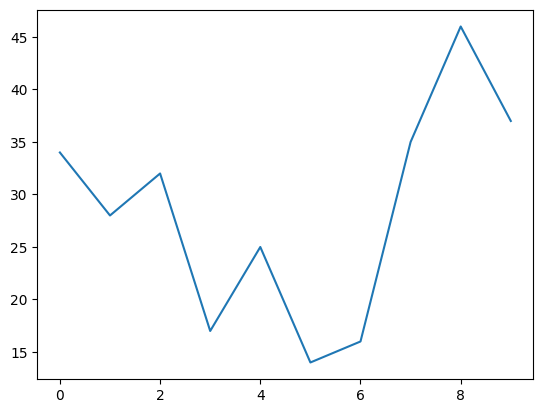

In [66]:
# Evaluamos el modelo GENERADOR en el TEST

# Definimos el entorno
env= gym.make('CartPole-v1')


rewards=[]
# Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
# siguiendo la política que se ha aprendido en el entrenamiento de la GAN
for episode in range(10):
    truncated=False
    terminated=False
    R=0.0
    reward=0.0

    # Estado inicial del juego
    obs,_=env.reset()

    #Interactuamos con el Entorno hasta que lleguemos a un estado final
    while terminated!= True and truncated!=True:
        action, _=generator.get_model().predict(obs)
        obs,reward,terminated,truncated,info=env.step(int(action))

        # Incremento la recompensa del episodio i al haber ejecutado el step
        R+=reward

    rewards.append(R)

    # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
    print("Episode  {} Total reward: {}".format(episode,R))

# Cierro el entorno
env.close()

# Muestro las recompensas obtenidas en cada episodio
indices = range(0, 10)
plt.plot(indices,rewards)
plt.show()